In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [21]:
df = pd.read_csv("../data/listings_cleaned.csv")

In [22]:
# Remove the dollar sign and convert the price column to float
df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)

In [23]:
df['property_type'].nunique()

81

### Removing long term renting

In [24]:
pd.set_option('display.max_columns', None)
short_df = df[['id', 'host_is_superhost', 'neighbourhood_group_cleansed', 	'room_type', 'accommodates', 'price', 'minimum_nights', 'availability_30', 'availability_60', 'availability_90', 'availability_365']]
short_df.head()

,id,host_is_superhost,neighbourhood_group_cleansed,room_type,accommodates,price,minimum_nights,availability_30,availability_60,availability_90,availability_365
0,9630344,0,Brooklyn,Private room,1,65.0,30,29,59,89,364
1,3533741,0,Manhattan,Private room,2,110.0,30,0,0,0,0
2,9731039,0,Queens,Entire home/apt,1,99.0,30,0,0,0,0
3,21736164,0,Brooklyn,Entire home/apt,2,70.0,45,0,0,0,0
4,22280002,1,Brooklyn,Entire home/apt,4,170.0,30,3,20,35,96


In [25]:
df.loc[df['minimum_nights'] > 180].count()

id                      151
name                    151
host_id                 151
host_since              151
host_is_superhost       151
                       ... 
has_tub                 151
has_disney              151
has_bluetooth           151
has_wardrobe            151
imputed_review_score    151
Length: 210, dtype: int64

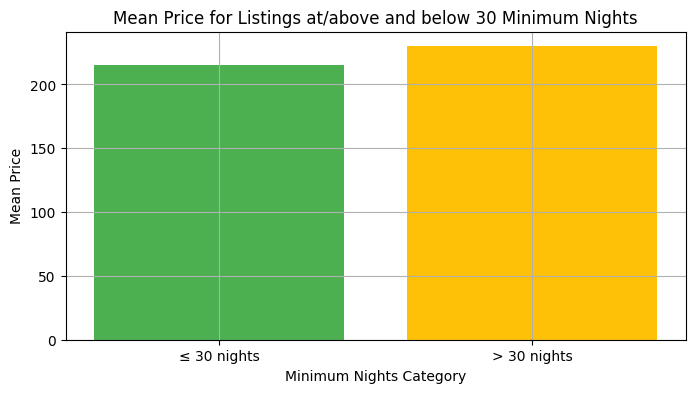

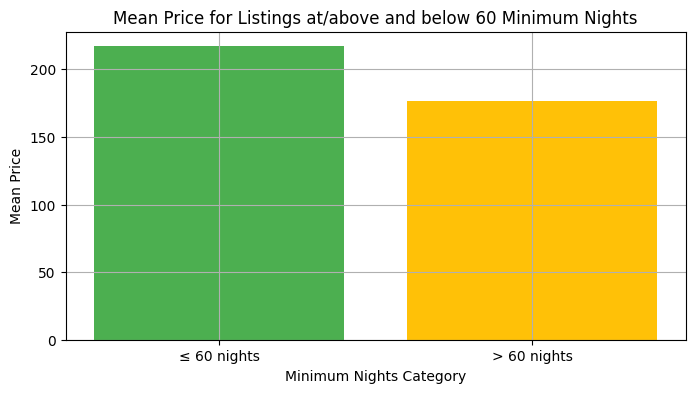

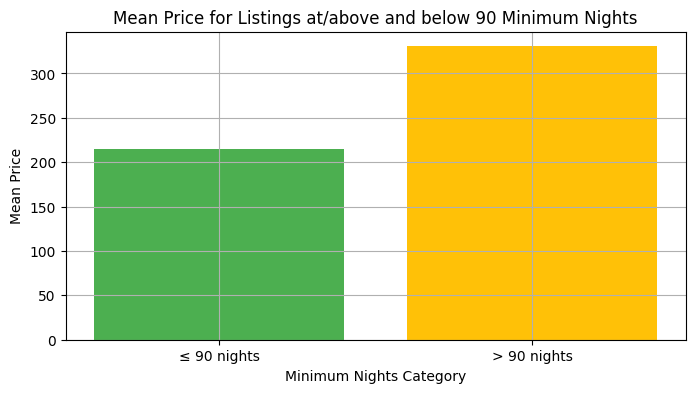

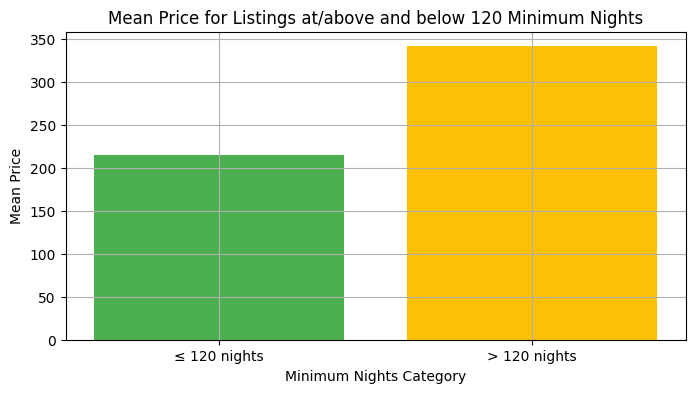

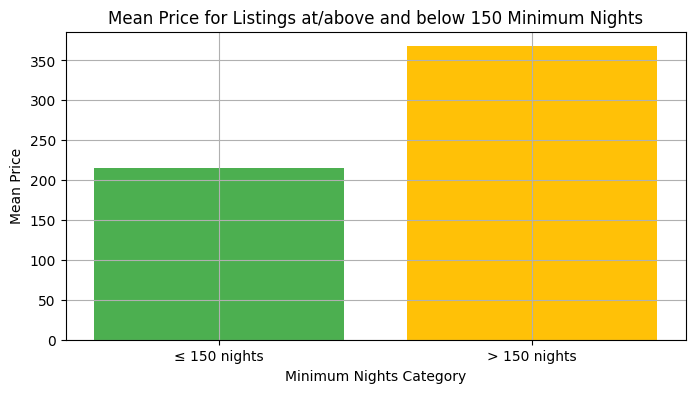

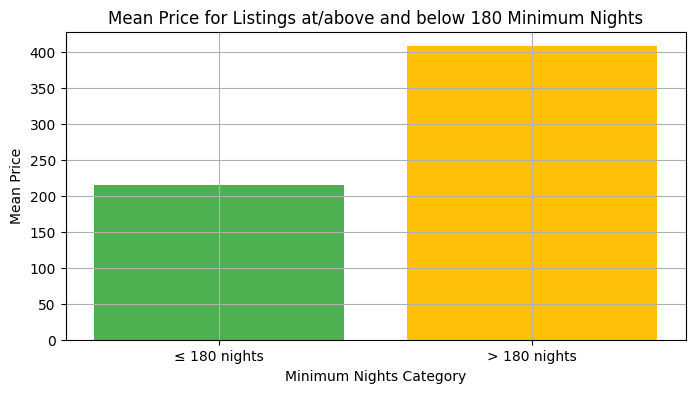

In [26]:
# Define the cutoff points
cutoffs = [30, 60, 90, 120, 150, 180]

# Calculate mean prices for each range and create plots
for cutoff in cutoffs:
    # Mean price for listings with minimum_nights at or below the cutoff
    mean_price_at_or_below = df[df['minimum_nights'] <= cutoff]['price'].mean()
    
    # Mean price for listings with minimum_nights above the cutoff
    mean_price_above = df[df['minimum_nights'] > cutoff]['price'].mean()

    # Prepare data for plotting
    mean_prices = [mean_price_at_or_below, mean_price_above]
    categories = [f'≤ {cutoff} nights', f'> {cutoff} nights']

    # Create a bar plot for the current cutoff
    plt.figure(figsize=(8, 4))
    plt.bar(categories, mean_prices, color=['#4CAF50', '#FFC107'])
    plt.title(f'Mean Price for Listings at/above and below {cutoff} Minimum Nights')
    plt.xlabel('Minimum Nights Category')
    plt.ylabel('Mean Price')
    plt.grid(True)
    plt.show()



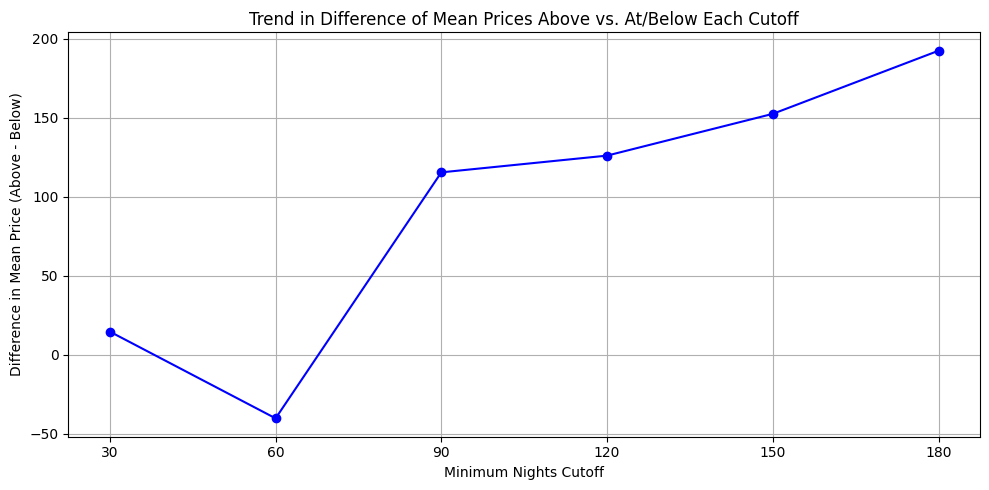

In [27]:
# Define the cutoff points
cutoffs = [30, 60, 90, 120, 150, 180]

# Initialize a list to store the differences in mean prices
price_differences = []

# Calculate mean prices for each range and store the differences
for cutoff in cutoffs:
    mean_price_at_or_below = df[df['minimum_nights'] <= cutoff]['price'].mean()
    mean_price_above = df[df['minimum_nights'] > cutoff]['price'].mean()
    # Calculate the difference as mean price above - mean price at or below
    price_difference = mean_price_above - mean_price_at_or_below
    price_differences.append(price_difference)

# Now, plot the differences in a line chart
plt.figure(figsize=(10, 5))
plt.plot(cutoffs, price_differences, marker='o', linestyle='-', color='b')
plt.title('Trend in Difference of Mean Prices Above vs. At/Below Each Cutoff')
plt.xlabel('Minimum Nights Cutoff')
plt.ylabel('Difference in Mean Price (Above - Below)')
plt.grid(True)
plt.xticks(cutoffs)  # Set x-ticks to be exactly at the cutoff points
plt.tight_layout()  # Adjust layout to ensure everything fits without overlap
plt.show()

### Clustering

In [28]:
short_df.columns

Index(['id', 'host_is_superhost', 'neighbourhood_group_cleansed', 'room_type',
       'accommodates', 'price', 'minimum_nights', 'availability_30',
       'availability_60', 'availability_90', 'availability_365'],
      dtype='object')

In [29]:
short_df.head()

,id,host_is_superhost,neighbourhood_group_cleansed,room_type,accommodates,price,minimum_nights,availability_30,availability_60,availability_90,availability_365
0,9630344,0,Brooklyn,Private room,1,65.0,30,29,59,89,364
1,3533741,0,Manhattan,Private room,2,110.0,30,0,0,0,0
2,9731039,0,Queens,Entire home/apt,1,99.0,30,0,0,0,0
3,21736164,0,Brooklyn,Entire home/apt,2,70.0,45,0,0,0,0
4,22280002,1,Brooklyn,Entire home/apt,4,170.0,30,3,20,35,96


In [31]:
short_df['neighbourhood_group_cleansed'].unique()

array(['Brooklyn', 'Manhattan', 'Queens', 'Bronx', 'Staten Island'],
      dtype=object)

C:\Users\heiwi\AppData\Local\Temp\ipykernel_5472\1702061182.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  short_df['accommodates_group'] = pd.cut(short_df['accommodates'], bins=bins_accommodates, labels=labels_accommodates, right=False)
C:\Users\heiwi\AppData\Local\Temp\ipykernel_5472\1702061182.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in short_df.groupby(['neighbourhood_group_cleansed', 'room_type', 'accommodates_group']):
c:\Users\heiwi\Documents\tdt4259-main\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: 

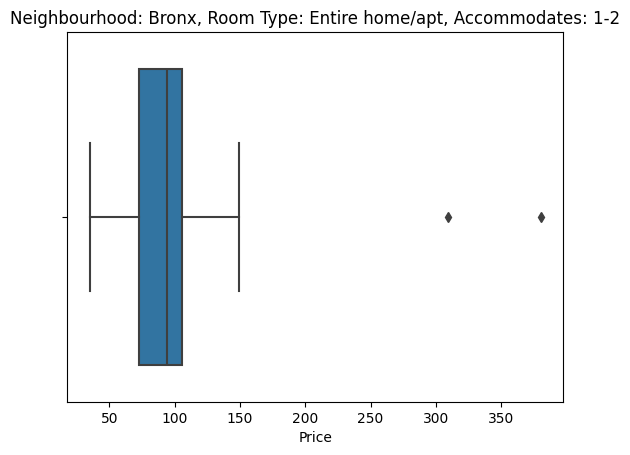

c:\Users\heiwi\Documents\tdt4259-main\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


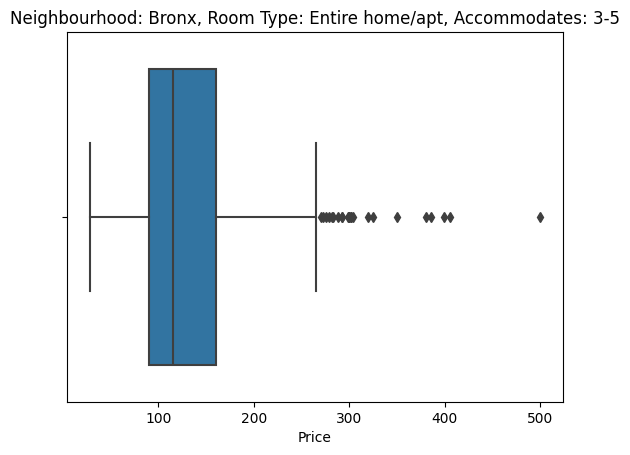

c:\Users\heiwi\Documents\tdt4259-main\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


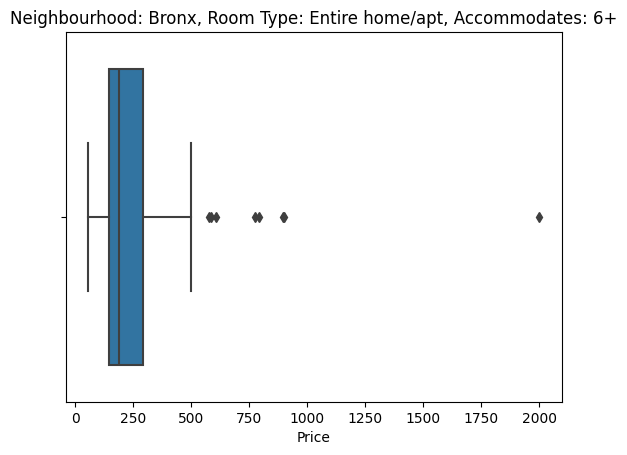

c:\Users\heiwi\Documents\tdt4259-main\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


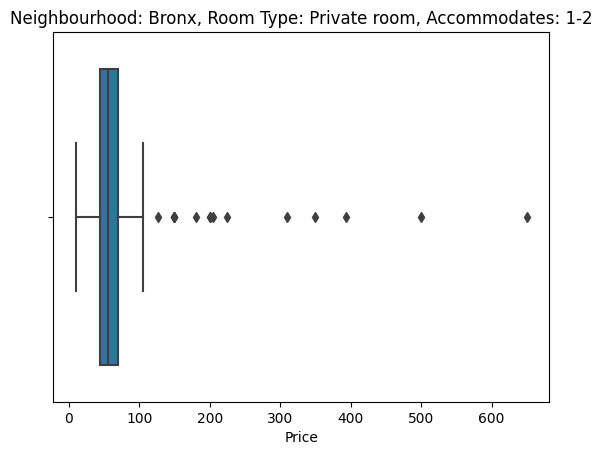

c:\Users\heiwi\Documents\tdt4259-main\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


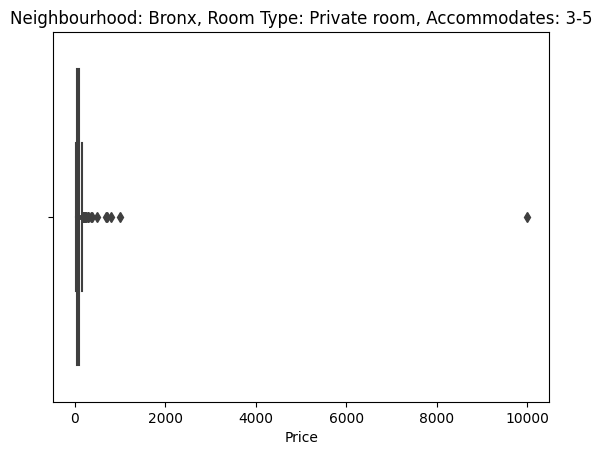

c:\Users\heiwi\Documents\tdt4259-main\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


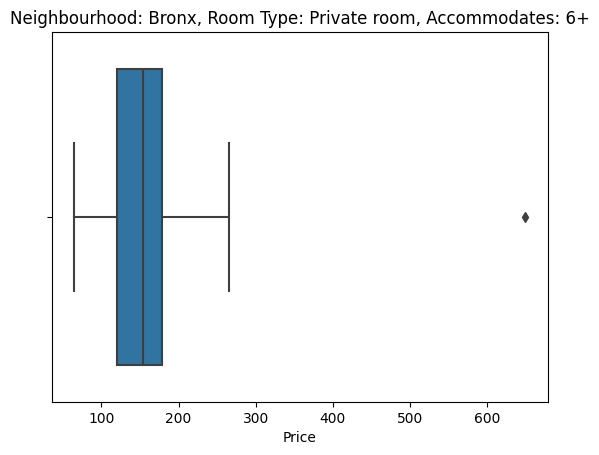

c:\Users\heiwi\Documents\tdt4259-main\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


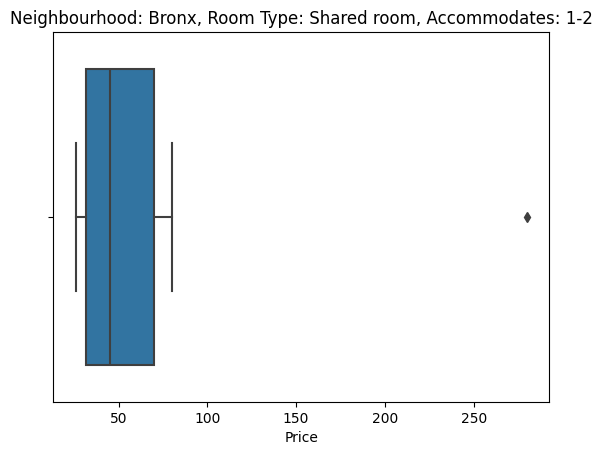

c:\Users\heiwi\Documents\tdt4259-main\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


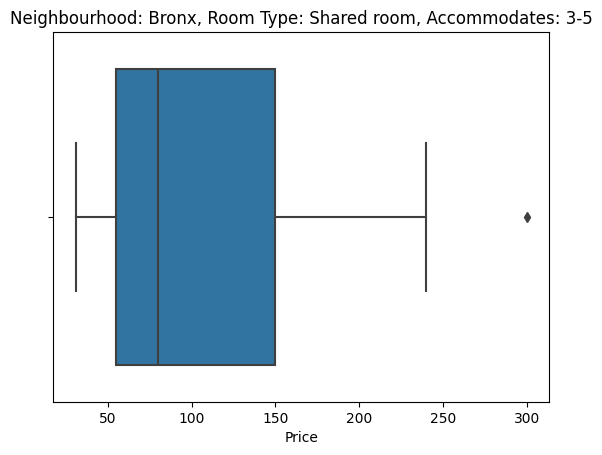

c:\Users\heiwi\Documents\tdt4259-main\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


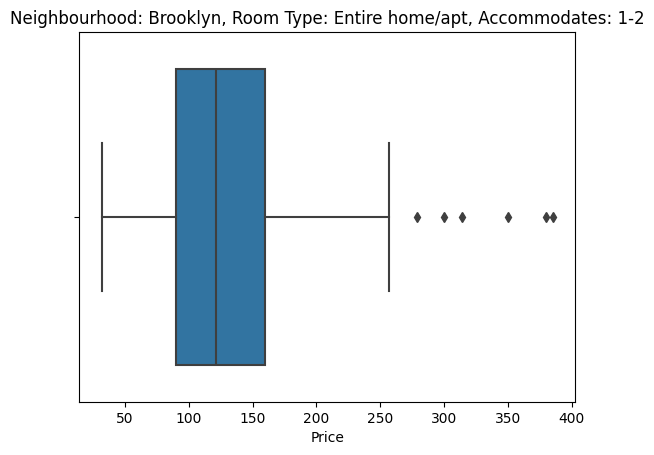

c:\Users\heiwi\Documents\tdt4259-main\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


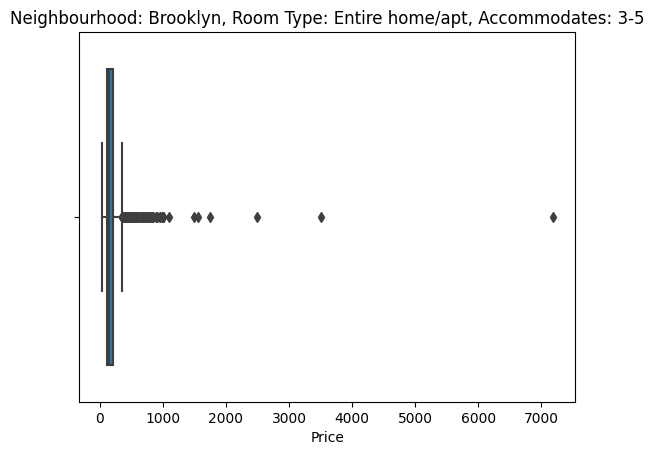

c:\Users\heiwi\Documents\tdt4259-main\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


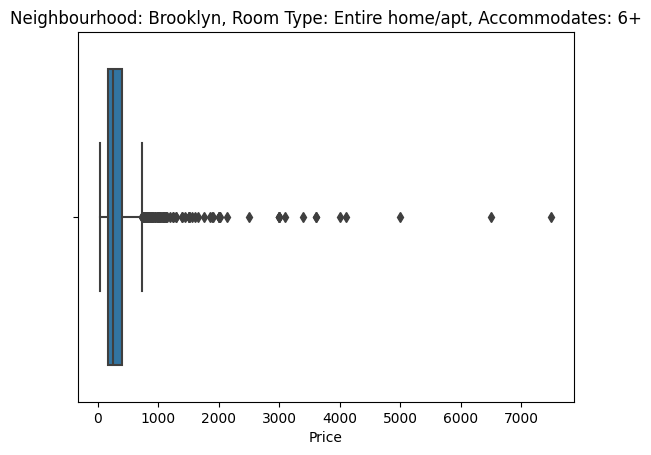

c:\Users\heiwi\Documents\tdt4259-main\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


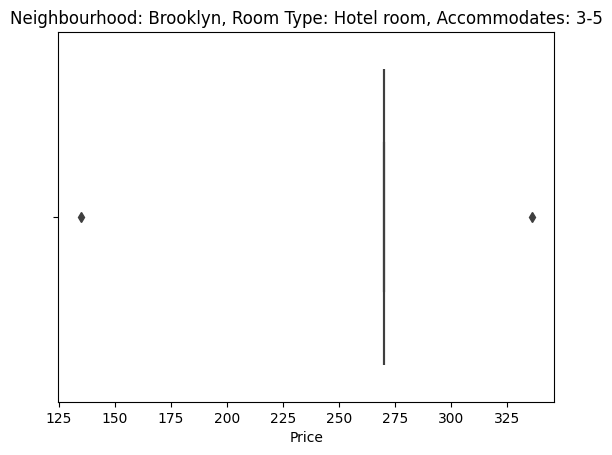

c:\Users\heiwi\Documents\tdt4259-main\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


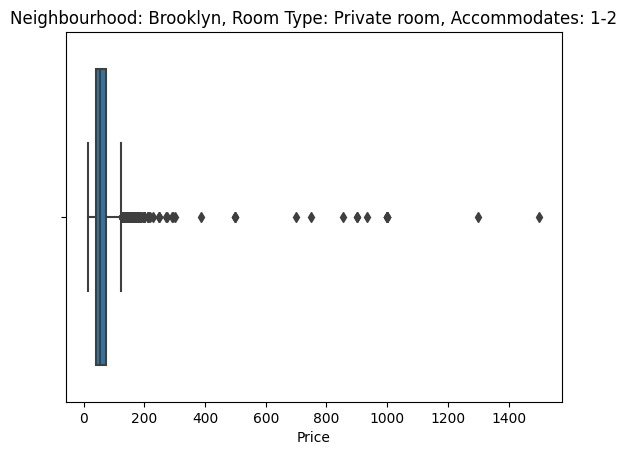

c:\Users\heiwi\Documents\tdt4259-main\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


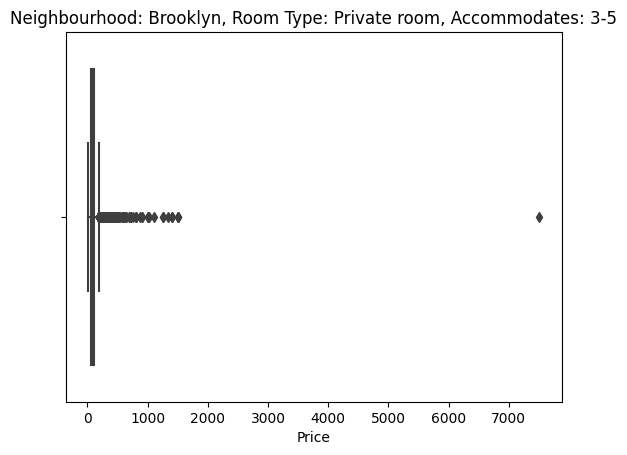

c:\Users\heiwi\Documents\tdt4259-main\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


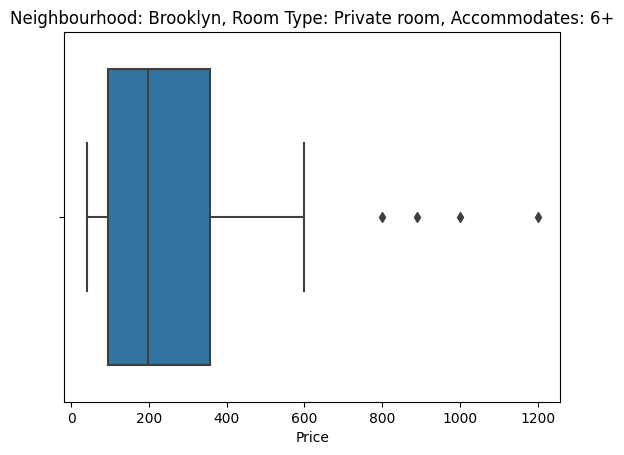

c:\Users\heiwi\Documents\tdt4259-main\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


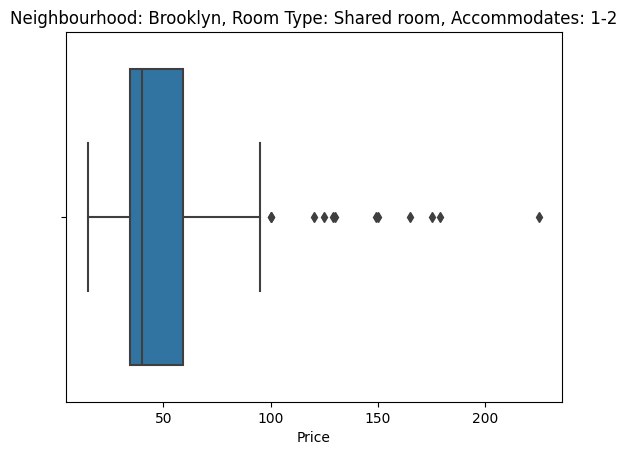

c:\Users\heiwi\Documents\tdt4259-main\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


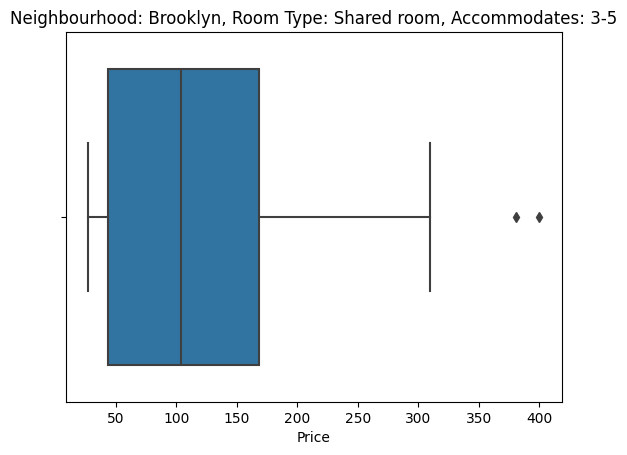

c:\Users\heiwi\Documents\tdt4259-main\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


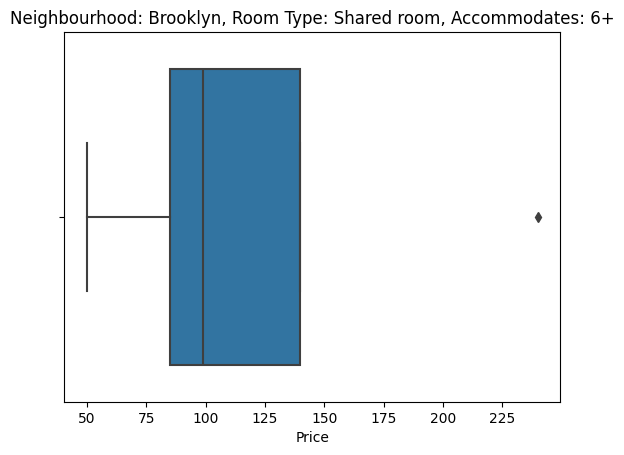

c:\Users\heiwi\Documents\tdt4259-main\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


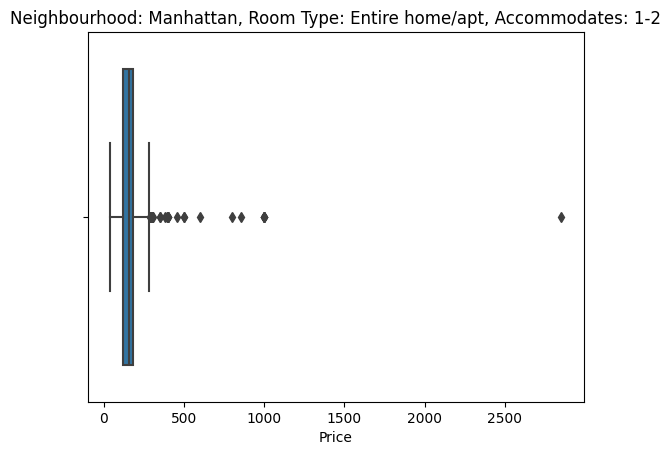

c:\Users\heiwi\Documents\tdt4259-main\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


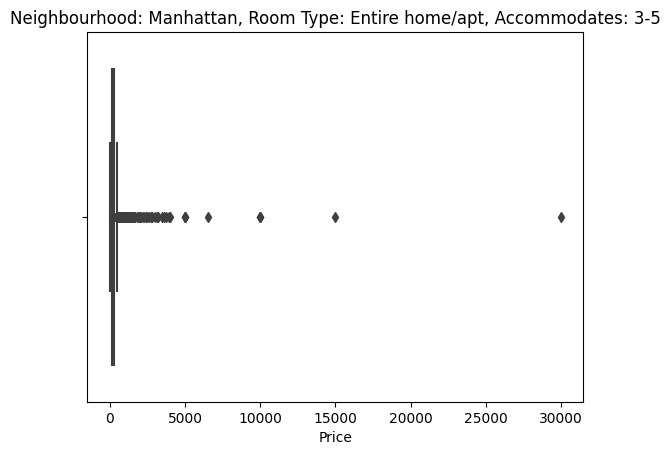

c:\Users\heiwi\Documents\tdt4259-main\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


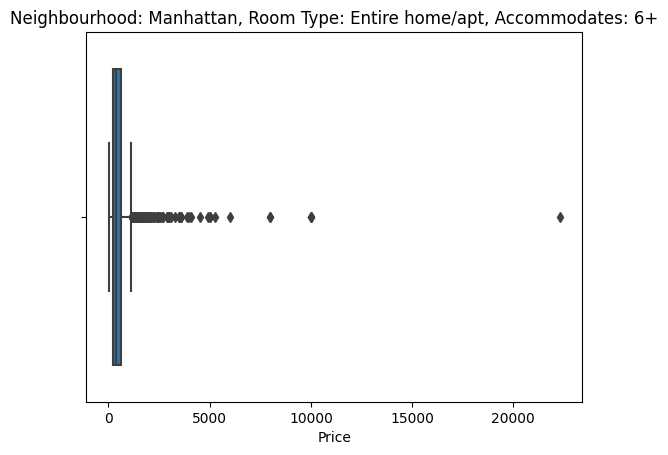

c:\Users\heiwi\Documents\tdt4259-main\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


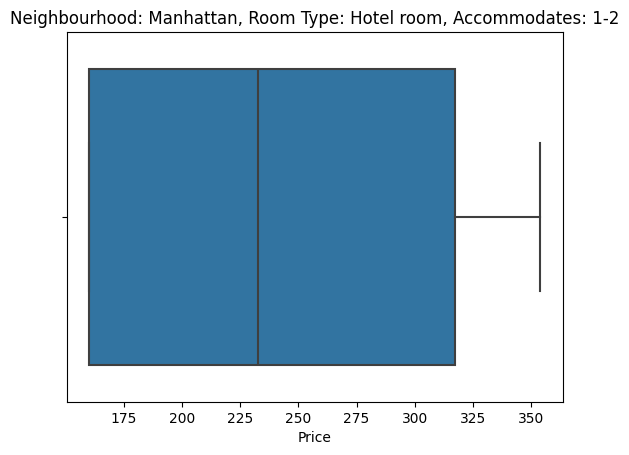

c:\Users\heiwi\Documents\tdt4259-main\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


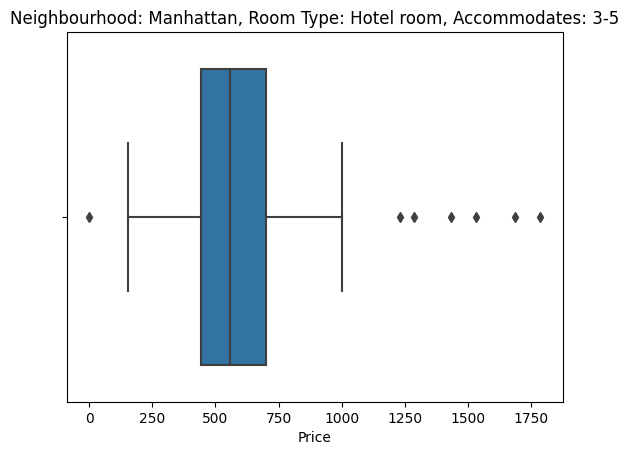

c:\Users\heiwi\Documents\tdt4259-main\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


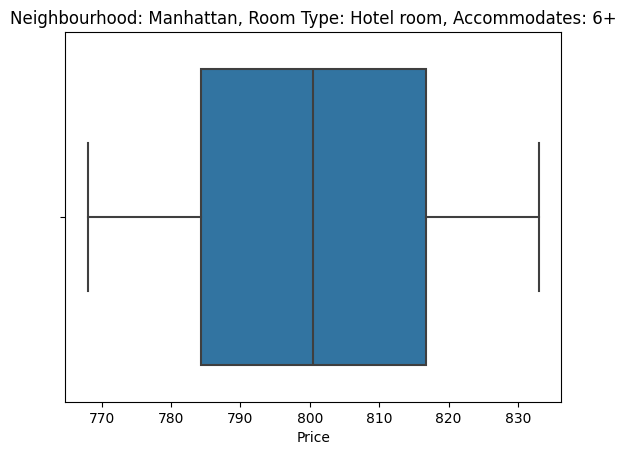

c:\Users\heiwi\Documents\tdt4259-main\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


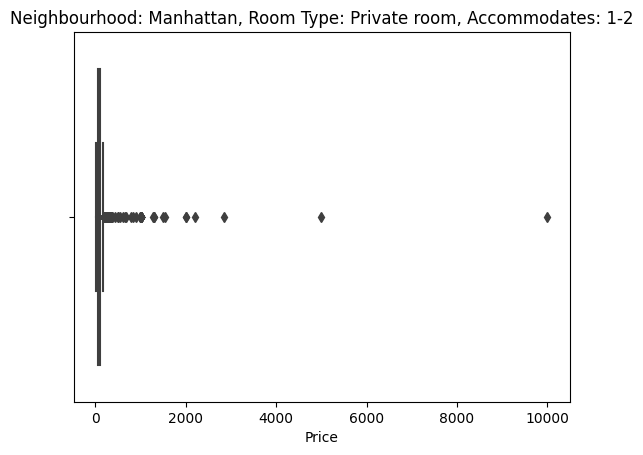

c:\Users\heiwi\Documents\tdt4259-main\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


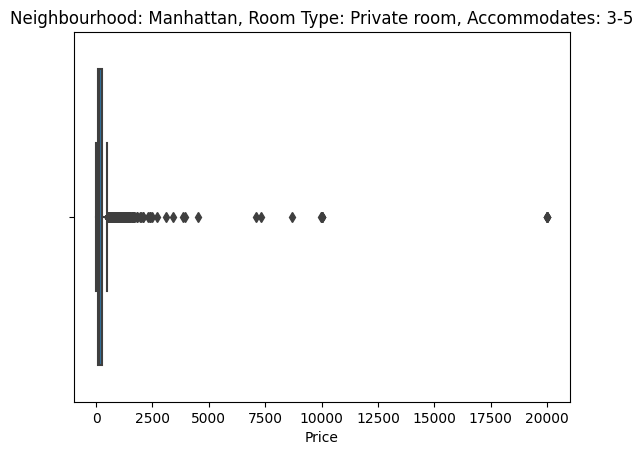

c:\Users\heiwi\Documents\tdt4259-main\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


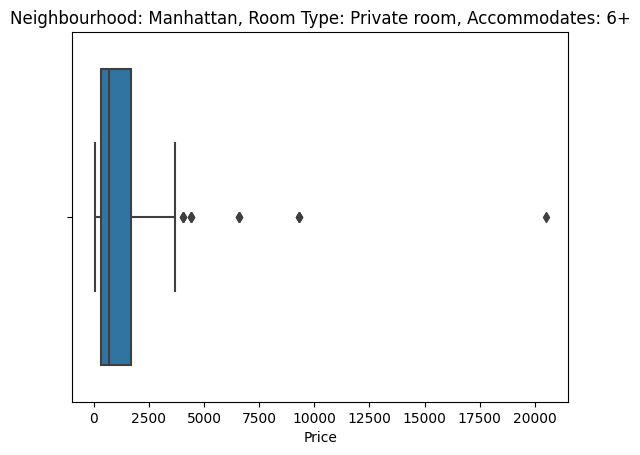

c:\Users\heiwi\Documents\tdt4259-main\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


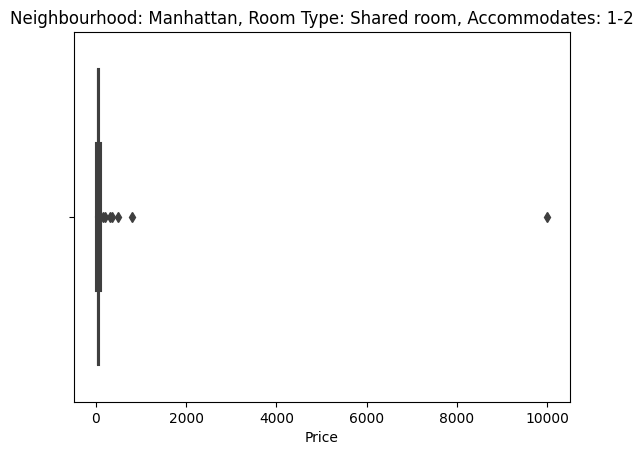

c:\Users\heiwi\Documents\tdt4259-main\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


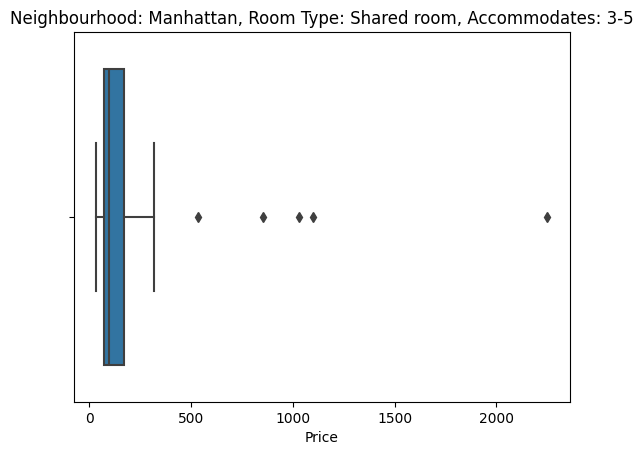

c:\Users\heiwi\Documents\tdt4259-main\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


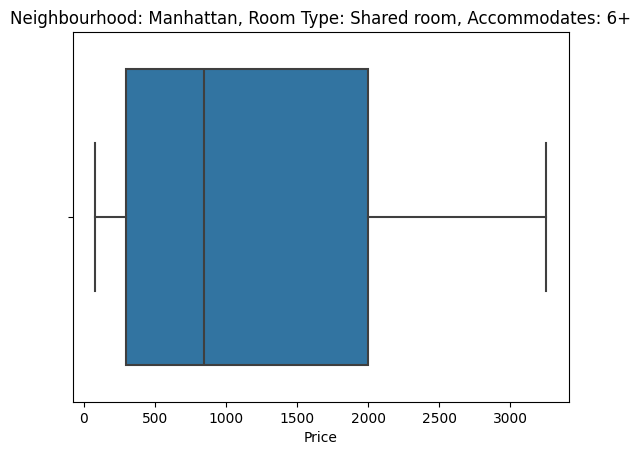

c:\Users\heiwi\Documents\tdt4259-main\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


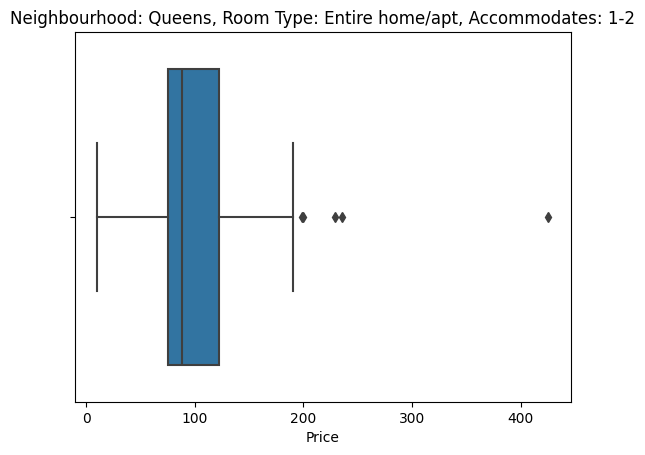

c:\Users\heiwi\Documents\tdt4259-main\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


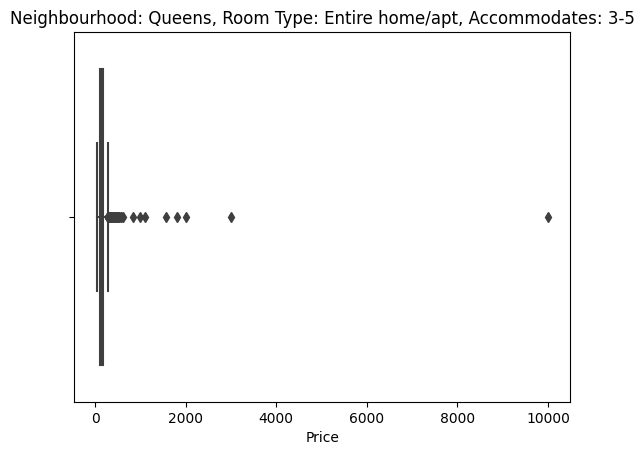

c:\Users\heiwi\Documents\tdt4259-main\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


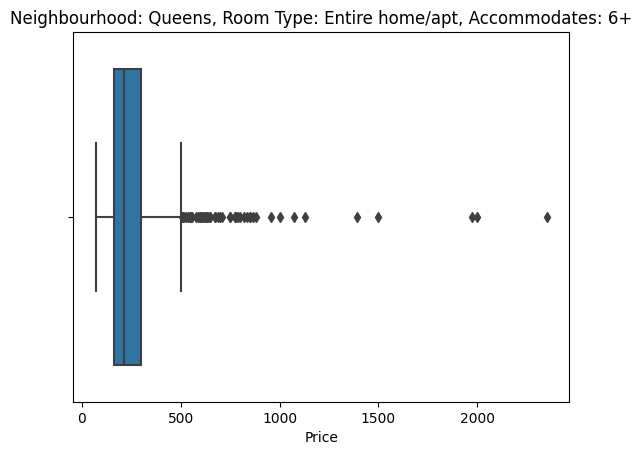

c:\Users\heiwi\Documents\tdt4259-main\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


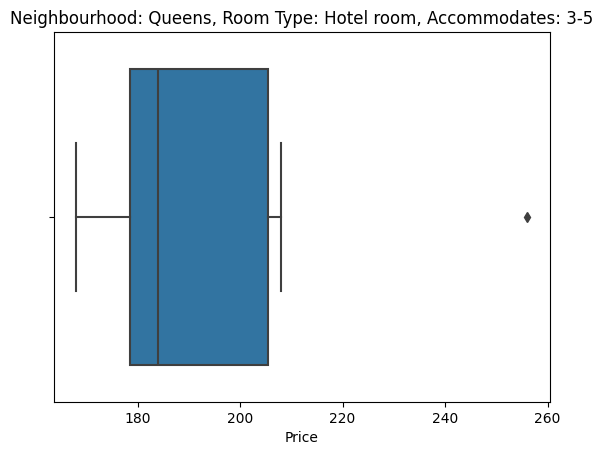

c:\Users\heiwi\Documents\tdt4259-main\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


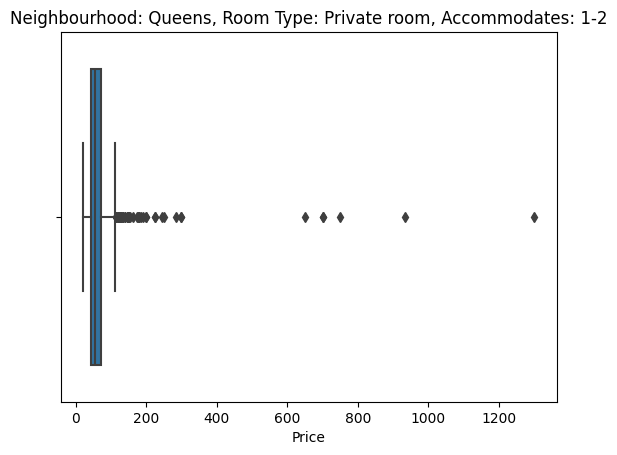

c:\Users\heiwi\Documents\tdt4259-main\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


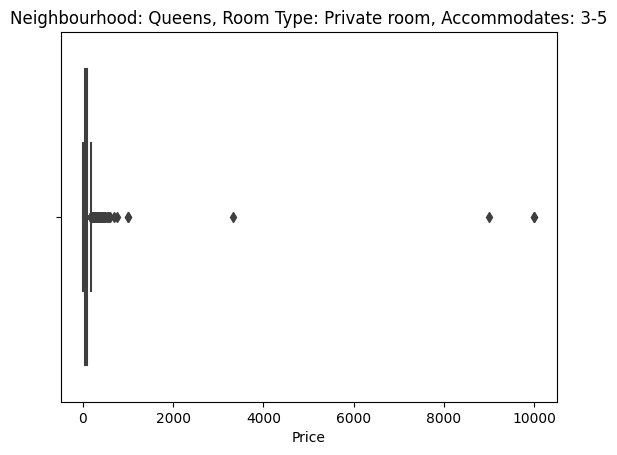

c:\Users\heiwi\Documents\tdt4259-main\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


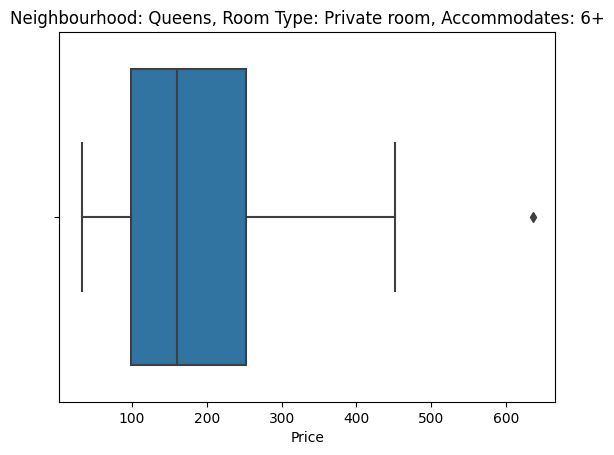

c:\Users\heiwi\Documents\tdt4259-main\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


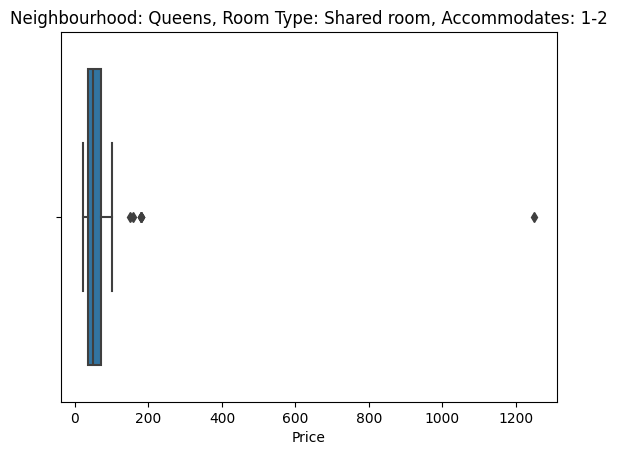

c:\Users\heiwi\Documents\tdt4259-main\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


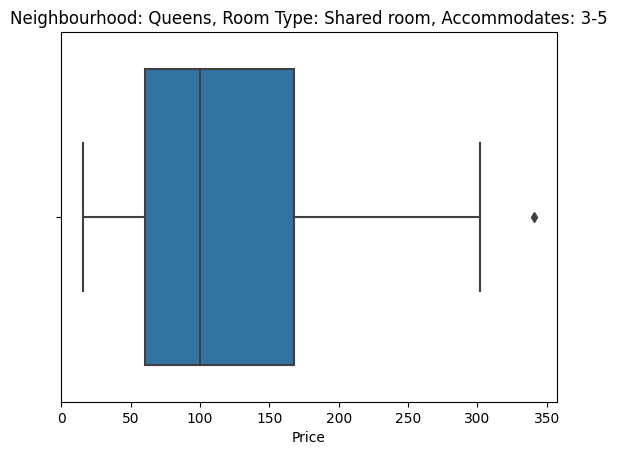

c:\Users\heiwi\Documents\tdt4259-main\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


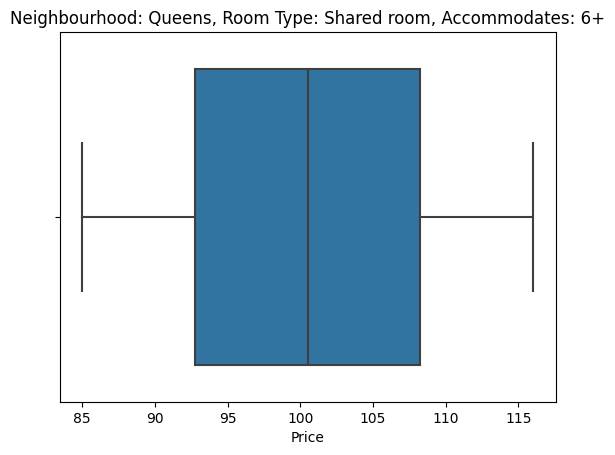

c:\Users\heiwi\Documents\tdt4259-main\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


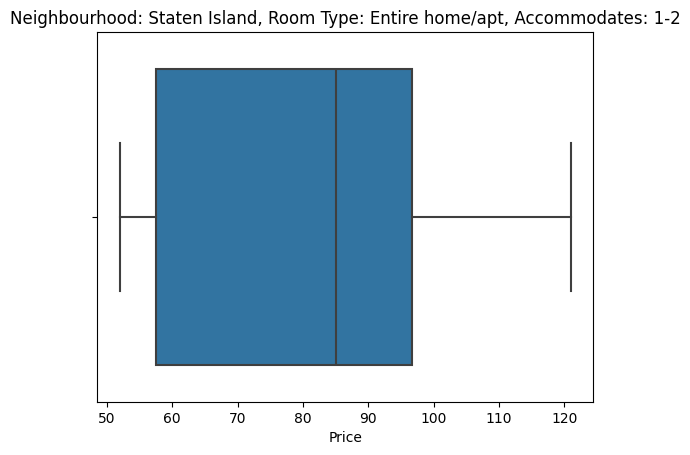

c:\Users\heiwi\Documents\tdt4259-main\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


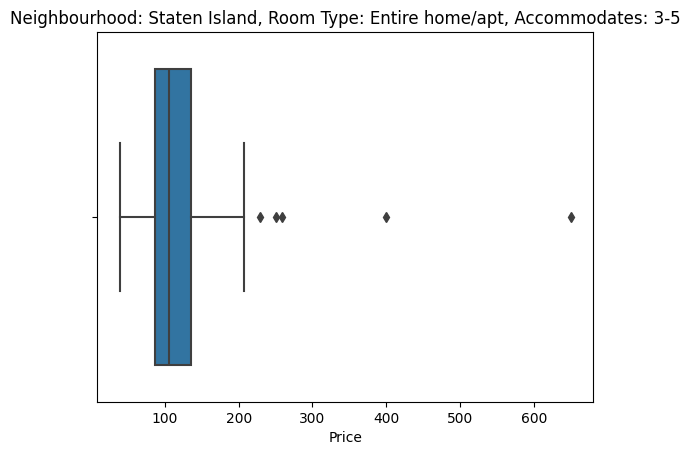

c:\Users\heiwi\Documents\tdt4259-main\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


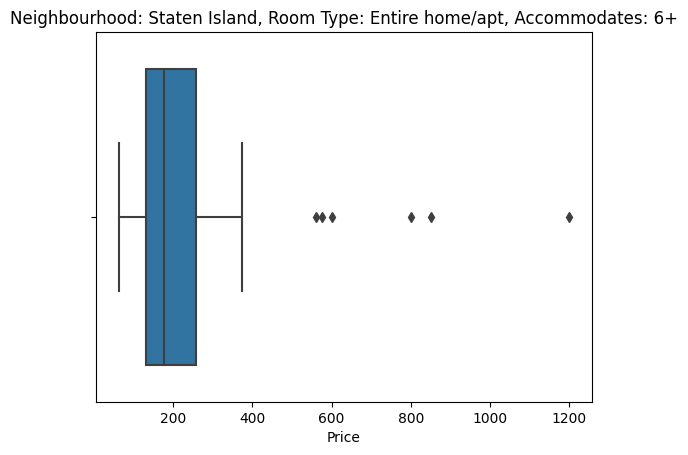

c:\Users\heiwi\Documents\tdt4259-main\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


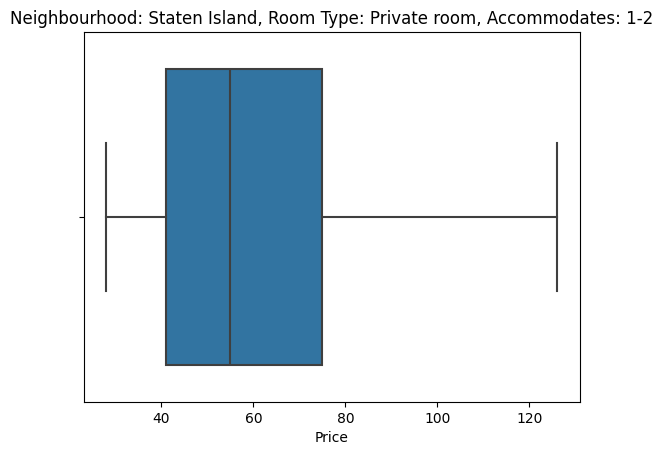

c:\Users\heiwi\Documents\tdt4259-main\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


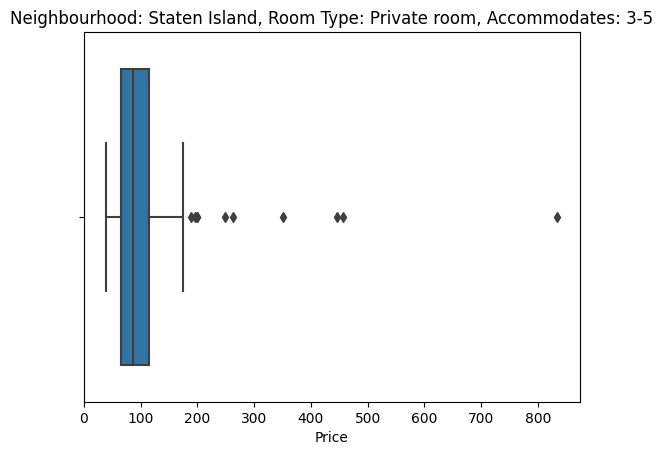

c:\Users\heiwi\Documents\tdt4259-main\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


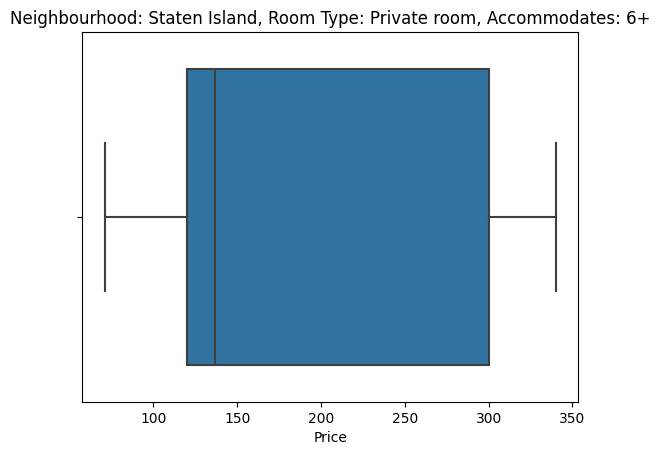

c:\Users\heiwi\Documents\tdt4259-main\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


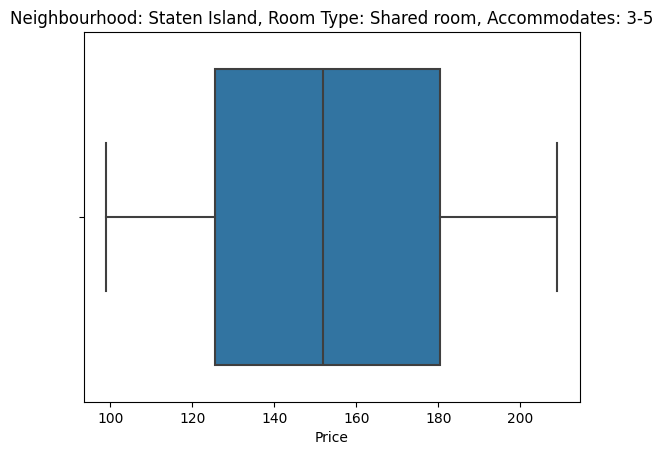

c:\Users\heiwi\Documents\tdt4259-main\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


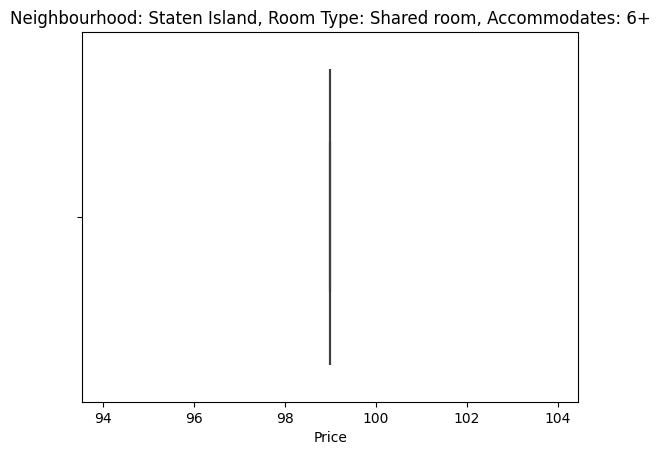

,id,host_is_superhost,neighbourhood_group_cleansed,room_type,accommodates,price,minimum_nights,availability_30,availability_60,availability_90,availability_365,accommodates_group,availability_90_group
0,768641960774104273,0,Bronx,Entire home/apt,1,309.0,30,14,36,61,335,1-2,51-60
1,48393913,0,Bronx,Entire home/apt,1,380.0,30,0,0,0,0,1-2,0-10
2,760108051671400285,0,Bronx,Entire home/apt,4,299.0,30,30,60,90,365,3-5,81-90
3,919634637929081011,0,Bronx,Entire home/apt,4,405.0,30,30,60,90,270,3-5,81-90
4,660817027795540122,0,Bronx,Entire home/apt,4,300.0,30,30,60,90,90,3-5,81-90
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2798,900756762692073591,0,Staten Island,Private room,2,195.0,60,30,60,90,365,3-5,81-90
2799,897126374414499880,0,Staten Island,Private room,2,446.0,30,0,0,29,304,3-5,21-30
2800,522425855620716170,1,Staten Island,Private room,2,834.0,30,25,45,45,298,3-5,41-50
2801,16123943,0,Staten Island,Private room,2,350.0,30,29,59,89,89,3-5,81-90


In [34]:
# Step 1: Categorize 'accommodates'
bins_accommodates = [0, 2, 5, float('inf')]  # Define the bins for 1-2, 3-5, 6+
labels_accommodates = ['1-2', '3-5', '6+']
short_df['accommodates_group'] = pd.cut(short_df['accommodates'], bins=bins_accommodates, labels=labels_accommodates, right=False)

# Create a list to store outliers
outlier_rows = []

# Step 2 & 3: Create the boxplots and find outliers
# Get unique combinations of 'neighbourhood_group_cleansed', 'room_type', and 'accommodates_group'
for name, group in short_df.groupby(['neighbourhood_group_cleansed', 'room_type', 'accommodates_group']):
    
    # Plot
    plt.figure()
    boxplot = sns.boxplot(data=group, x='price')
    plt.title(f'Neighbourhood: {name[0]}, Room Type: {name[1]}, Accommodates: {name[2]}')
    plt.xlabel('Price')
    plt.show()
    
    # Find outliers
    Q1 = group['price'].quantile(0.25)
    Q3 = group['price'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - (1.5 * IQR)
    upper_bound = Q3 + (1.5 * IQR)
    
    # Filter the group for outliers
    outliers = group[(group['price'] < lower_bound) | (group['price'] > upper_bound)]
    outlier_rows.append(outliers)
    
# Step 4: Concatenate the list of outlier dataframes
outlier_df = pd.concat(outlier_rows, ignore_index=True)

# Print the outlier data
outlier_df

c:\Users\heiwi\Documents\tdt4259-main\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\heiwi\Documents\tdt4259-main\venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


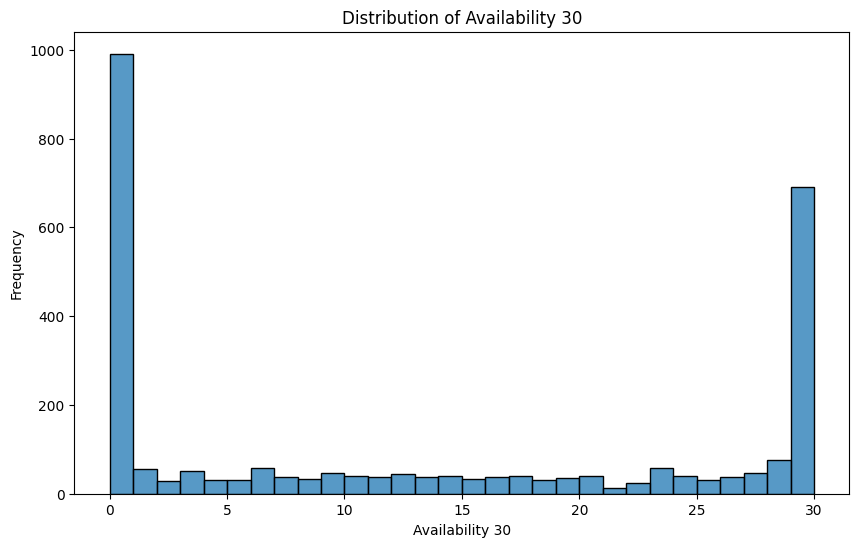

c:\Users\heiwi\Documents\tdt4259-main\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\heiwi\Documents\tdt4259-main\venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


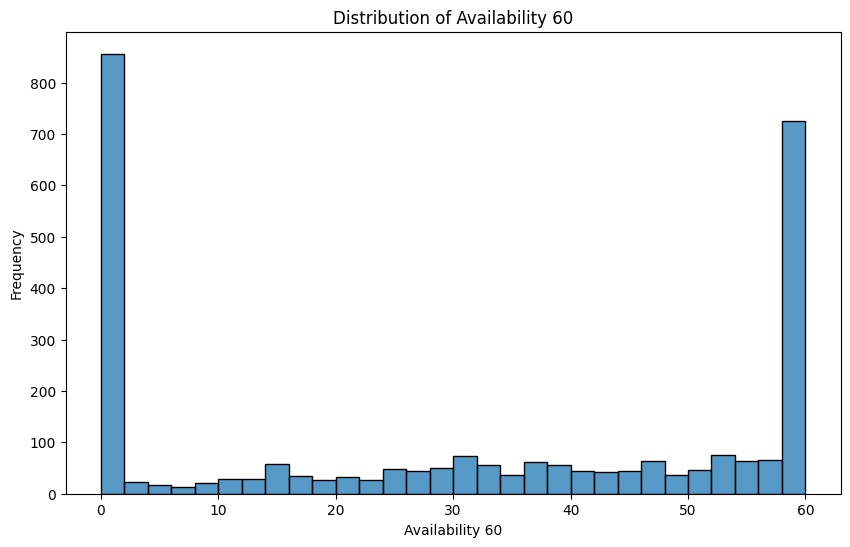

c:\Users\heiwi\Documents\tdt4259-main\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\heiwi\Documents\tdt4259-main\venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


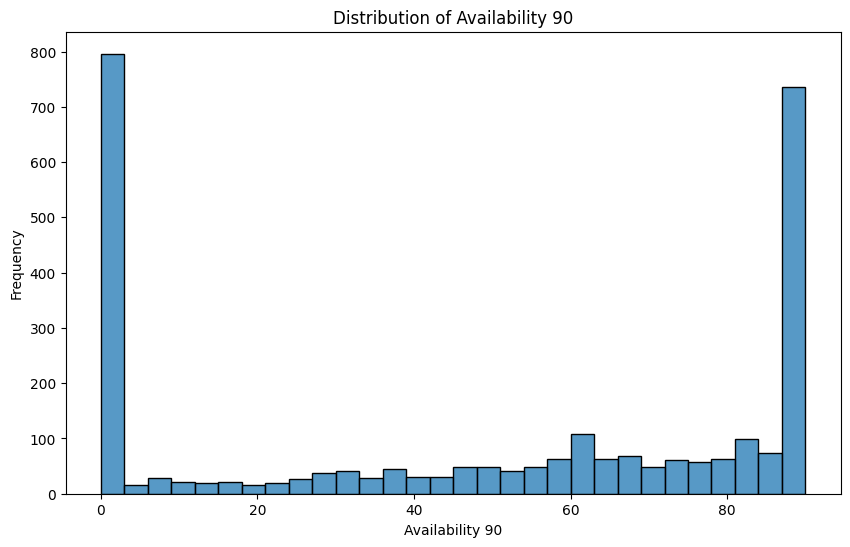

c:\Users\heiwi\Documents\tdt4259-main\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\heiwi\Documents\tdt4259-main\venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


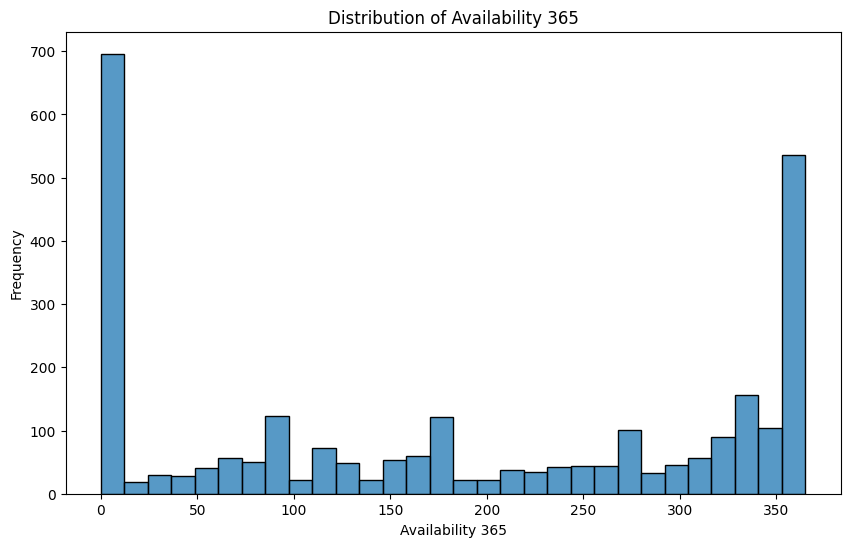

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assume outlier_df is the DataFrame containing the outliers

# Plot distribution for 'availability_30'
plt.figure(figsize=(10, 6))
sns.histplot(outlier_df['availability_30'], kde=False, bins=30)
plt.title('Distribution of Availability 30')
plt.xlabel('Availability 30')
plt.ylabel('Frequency')
plt.show()

# Plot distribution for 'availability_60'
plt.figure(figsize=(10, 6))
sns.histplot(outlier_df['availability_60'], kde=False, bins=30)
plt.title('Distribution of Availability 60')
plt.xlabel('Availability 60')
plt.ylabel('Frequency')
plt.show()

# Plot distribution for 'availability_90'
plt.figure(figsize=(10, 6))
sns.histplot(outlier_df['availability_90'], kde=False, bins=30)
plt.title('Distribution of Availability 90')
plt.xlabel('Availability 90')
plt.ylabel('Frequency')
plt.show()

# Plot distribution for 'availability_365'
plt.figure(figsize=(10, 6))
sns.histplot(outlier_df['availability_365'], kde=False, bins=30)
plt.title('Distribution of Availability 365')
plt.xlabel('Availability 365')
plt.ylabel('Frequency')
plt.show()
